In [142]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

rc('font', family='NanumGothic')

dates = ['20120411', '20160413', '20200415', '20240410']

In [143]:
class Candidate:
    def __init__(self, party: str, name: str, votes: float):
        self.party = party
        self.name = name
        self.votes = votes

    def __str__(self):
        return str((self.party, self.name, self.votes))

In [144]:
# 0: 극우
# 1: 보수
# 2: 중도
# 3: 진보
# 4: 극좌

def party_to_spectrum(d_i: int, city: str, candidate: Candidate) -> list[int]:
    f = open(f'election_change\\{dates[d_i]}-party.csv', 'r', encoding='UTF-8')
    result = []
    for line in f:
        line = line.split(',')

        if line[0] == candidate.party:
            if candidate.party != '무소속':
                result = list(map(int, line[3:]))
                break
            if line[1] == city and line[2] == candidate.name:
                result = list(map(int, line[3:]))
                break
    
    f.close()
    return result

def get_party_color(spectrums: list[int]):
    if len(spectrums) == 0:
        return (0.5, 0.5, 0.5)
    colors = [(1, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0)]
    return colors[spectrums[0]]

In [145]:
def get_prev_district(d_i: int, city: str, district_name: str):
    prev_file = open(f'election_change\\{dates[d_i]}-district.csv', 'r')
    prev_city = city

    if d_i == 3:
        if city == '강원특별자치도':
            prev_city = '강원도'
        elif city == '전북특별자치도':
            prev_city = '전라북도'
        
    for line in prev_file:
        line = line.split(',')

        if line[0] == city and line[1] == district_name:
            result = []
            i = 2
            
            while i < len(line):
                if d_i == 3 and line[i] == '군위군의성군청송군영덕군':
                    prev_city = '경상북도'
                        
                result.append((prev_city, line[i], int(line[i + 1])))
                i += 2
            return result
        
    return [(prev_city, district_name, 1)]

In [146]:
data = []

for date in dates:
    election_file = open(f'election_data\\{date}-district.csv', 'r')
    election_data = {}
    party_set = set()

    for line in election_file:
        row = {}

        line = line.split(',')
        city = line[0]
        district_name = line[1].strip()

        election_data.setdefault(city, {})

        idx = 2
        results = []

        while idx < len(line):
            party, name, votes = line[idx:idx+3]
            votes = float(votes)

            results.append(Candidate(party, name, votes))
            idx += 3

            if votes >= 10:
                party_set.add(party)

        election_data[city][district_name] = results
        if date == dates[0]:
            continue
    
    data.append(election_data)

In [147]:
def propagate_voters(base: int, vote_dist, curr: int):
    if len(vote_dist[curr]) > 0:
        return vote_dist[curr]
    
    new_vote_dist = []
    if curr >= base and curr + 1 < len(vote_dist):
        new_vote_dist.extend(propagate_voters(base, vote_dist, curr + 1))

    if curr <= base and curr - 1 >= 0:
        new_vote_dist.extend(propagate_voters(base, vote_dist, curr - 1))
    
    # Suppose the people supporting the spectrum moves to adjacent spectrum by 50-50
    # If no candidate exists
    return [(candidate, weight * 0.5) for (candidate, weight) in new_vote_dist]


def predict_prev_election(d_i: int, city: str, district_name: str) -> list[Candidate]:
    curr_data = data[d_i][city][district_name]

    # Get amount of votes that each spectrum got
    bucket = [0 for _ in range(5)]
    prev_districts = get_prev_district(d_i, city, district_name)
    
    for (prev_city, prev_district, weight) in prev_districts:
        for candidate in data[d_i - 1][prev_city][prev_district]:
            spectrums = party_to_spectrum(d_i - 1, prev_city, candidate)
            for s in spectrums:
                bucket[s] += weight * candidate.votes / len(spectrums)
    
    # Calculate how is the vote is going to be distributed, based on spectrum
    vote_dist = [[] for _ in range(5)]
    for c_i, candidate in enumerate(curr_data):
        spectrums = party_to_spectrum(d_i, city, candidate)
        for s in spectrums:
            vote_dist[s].append((c_i, 1 / len(spectrums)))

    # For empty vote_dist bucket (which means no candidate), propagate voters to adjacent spectrum
    vote_dist_original = vote_dist[:]
    for s, d in enumerate(vote_dist):
        if len(d) == 0:
            propagate_voters(s, vote_dist_original, s)

    # Distribute the votes from the previous result to the result
    vote_prediction = [0.0 for _ in curr_data]
    for s, dist_list in enumerate(vote_dist):
        weight_sum = sum(map(lambda x: x[1], dist_list))
        for (c, weight) in dist_list:
            vote_prediction[c] += weight / weight_sum * bucket[s]

    # Normalize the sum
    vote_sum = sum(vote_prediction)
    for n in range(len(vote_prediction)):
        vote_prediction[n] /= vote_sum / 100

    result = []
    for c_i, candidate in enumerate(curr_data):
        prediction = vote_prediction[c_i]
        result.append(Candidate(candidate.party, candidate.name, prediction))
    
    return result

In [156]:
class PredictionEval:
    def __init__(self, d_i: int, real: list[list[Candidate]], prediction: list[list[Candidate]]):
        self.d_i = d_i
        self.real = real
        self.prediction = prediction

    def find_winner(self, result: list[Candidate]):
        winner = result[0]

        for candidate in result:
            if candidate.votes > winner.votes:
                winner = candidate

        return winner
    
    def get_seats(self):
        pred_bin = {}
        real_bin = {}

        for pred, real in  zip(self.prediction, self.real):
            pred_winner = self.find_winner(pred)
            real_winner = self.find_winner(real)

            pred_bin[pred_winner.party] = pred_bin.setdefault(pred_winner.party, 0) + 1
            real_bin[real_winner.party] = real_bin.setdefault(real_winner.party, 0) + 1

        return pred_bin, real_bin


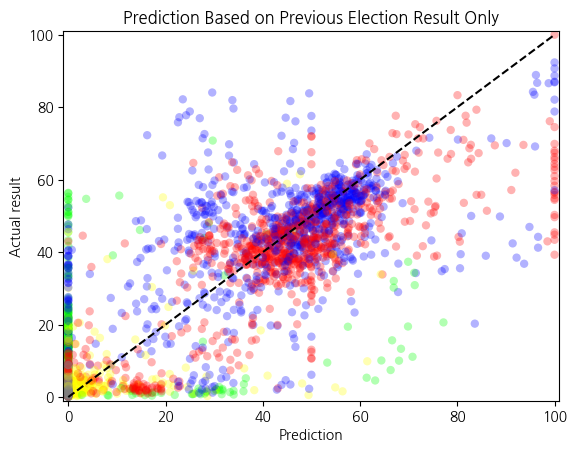

In [157]:
X = []
Y = []
colors = []
evalulators = []

for i in range(1, len(dates)):
    real_list = []
    pred_list = []

    for city in data[i].keys():
        for district_name in data[i][city].keys():
            prediction = predict_prev_election(i, city, district_name)
            result = data[i][city][district_name]

            pred_list.append(prediction)
            real_list.append(result)

            colors.extend(map(lambda x: get_party_color(party_to_spectrum(i, city, x)), result))
            X.extend(map(lambda x: x.votes, prediction))
            Y.extend(map(lambda x: x.votes, result))

            # Get candidate with most vote
            prediction.sort(key=lambda x: x.votes, reverse=True)
            result.sort(key=lambda x: x.votes, reverse=True)

    evalulators.append(PredictionEval(i, real_list, pred_list))

line = [x for x in range(101)]

plt.xlim(-1, 101)
plt.ylim(-1, 101)
plt.title('Prediction Based on Previous Election Result Only')
plt.xlabel('Prediction')
plt.ylabel('Actual result')

plt.plot((0, 100), (0, 100), 'k--')
plt.scatter(X, Y, c=colors, alpha=0.3, edgecolors='none')

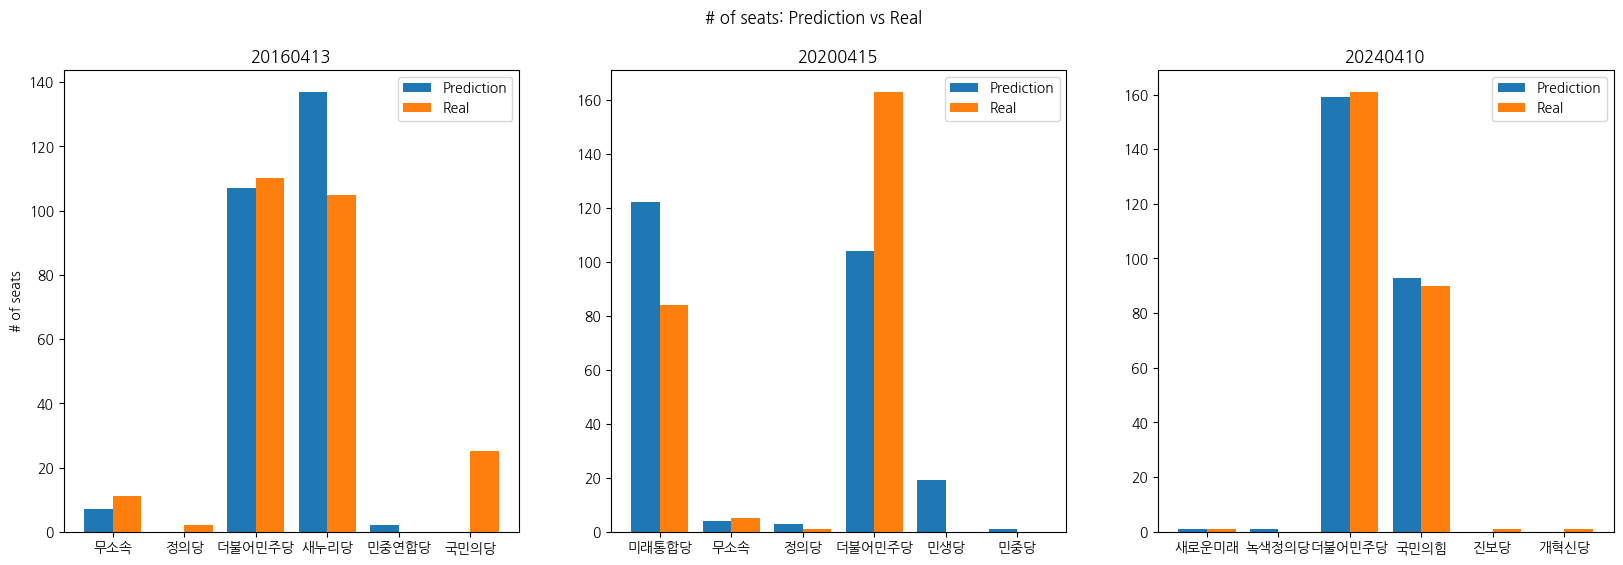

In [159]:
fig, axes = plt.subplots(1, len(evalulators), figsize=(20, 6))
fig.suptitle('# of seats: Prediction vs Real')
d_i = 1

axes[0].set_ylabel('# of seats')

for e, ax  in zip(evalulators, axes):
    pred, real = e.get_seats()

    party = list(set(pred.keys()).union(real.keys()))
    X_axis = np.arange(len(party))

    new_pred, new_real = [], []

    for p in party:
        new_pred.append(pred.get(p, 0))
        new_real.append(real.get(p, 0))

    ax.bar(X_axis - 0.2, new_pred, 0.4, label='Prediction')
    ax.bar(X_axis + 0.2, new_real, 0.4, label='Real')
    ax.set_xticks(X_axis, party)

    ax.set_title(dates[e.d_i])
    ax.legend()